<a href="https://colab.research.google.com/github/nuriaprol/UFV_Visualizacion/blob/main/EjerciciosClase%20/Clase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.ufv.es/wp-content/uploads/2023/03/logo-UFV-scaled.jpg" alt="Logo de Colab" width="200">

# <font color='00008B'>Práctica de Python 1.</font>
##### Nuria Prol Vecoña
# <font color='00008B'>Ventas en Europa</font>
#####Visualización de Datos


---

In [189]:
!pip install plotly-express

from google.colab import files
from matplotlib import pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


Librerías:
- matplotlib: para generar gráficos
- seaborn: para trabajar con paletas de colores.
- plotly_express: para crear gráficos interactivos

In [190]:
ventas = pd.read_csv("datos_ejercicio_ventas.csv")
ventas.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491


Una vez tenemos la base de datos cargada comenzamos con el análisis de la misma.
Primero vemos lo que significa cada variable.
- **Country:** País donde se realizó la venta
- **Subrand:** Marca específica del producto
- **Year y Month:** El año y més para los cuales la predicción fue hecha
- **Scenario:** Indica si el dato es una predicción realizada por IA (AI_forecast) o un valor actual (actual).
- **Forecast**: Mes en que se realizó la predicción, donde cada etiqueta (AI_P02F, AI_P03F, etc.) corresponde a un mes específico (Enero, Febrero, etc.).
- **Forecast Year:** El año en que se realizó la predicción.
- **Amount**: Cantidad de venta o pronóstico en unidades monetarias.


#PREPROCESAMIENTO

In [191]:
nan_por_columna = ventas.isna().sum()

total_nan = ventas.isna().sum().sum()

print("Valores NaN por columna:\n", nan_por_columna)
print("\nTotal de valores NaN en el DataFrame:", total_nan)

Valores NaN por columna:
 COUNTRY            0
SUBBRAND           0
YEAR               0
MONTH              0
SCENARIO           0
FORECAST         900
FORECAST_YEAR    900
AMOUNT             0
dtype: int64

Total de valores NaN en el DataFrame: 1800


Como los na están solo en las variables "Forecast" y "Forecast_Year" no es necesario eliminarlos, ya que estos datos solo se rellenan en el caso de que "SCENARIO" sea AI_forecast ya que se está tratando una predicción. Si "SCENARIO" es actual entonces en las variables Forecast y Forecast_year no habrá ningún valor.

### Duplicados

In [192]:
print("Número de registros antes de eliminar duplicados:", len(ventas))


duplicados = ventas.duplicated()
print("Número de registros duplicados:", duplicados.sum())

ventas = ventas.drop_duplicates()
print("Número de registros después de eliminar duplicados:", len(ventas))

Número de registros antes de eliminar duplicados: 18666
Número de registros duplicados: 663
Número de registros después de eliminar duplicados: 18003


###Negativos

Si tenemos datos negativos es porque hubo un error al introducirlos por lo que procedemos a eliminarlos

In [193]:
ventas = ventas[ventas['AMOUNT'] >= 0]

#ANÁLISIS BASE DE DATOS

Para seguir entendiendo nuestro dataset analizamos cuantos datos de los que hay en el dataset son predicciones y cuantos son valores actuales.
Esro lo haremos a través de un grafico de tarta para poder dimensionar a partir del 100% de nuestros datos cuantos son predicciones y cuantos valores actuales

In [194]:
fig = px.pie(
    ventas,
    names='SCENARIO',
    title='Distribución de "actual" vs "AI_forecast"',
    color_discrete_sequence=['#ffad66', '#ff6f61']
)

fig.update_traces(hovertemplate="<b>%{label}</b><br>%{value:,}")
fig.show()

##Separación entre actuals y forecasts


Ahora guardaremos en una variable aparte las filas de datos que contengan las ventas reales y no las predicciones para poder estudiarlas.

In [195]:
ventas_actual = ventas.copy()
ventas_actual = ventas_actual[ventas['SCENARIO'] == 'actual']
ventas_actual['Fecha'] = pd.to_datetime(ventas_actual['YEAR'].astype(str) + '-' + ventas_actual['MONTH'].astype(str))
ventas_actual.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,Fecha
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,NaN,1.885949e+05,2023-10-01
278,Portugal,7up (L3),2023,3,actual,NaN,NaN,2.934971e+05,2023-03-01
279,Portugal,7up (L3),2023,10,actual,NaN,NaN,3.484466e+05,2023-10-01
280,Great Britain,7up Free (L3),2023,10,actual,NaN,NaN,1.172553e+06,2023-10-01
281,Norway,Pepsi Regular (L3),2023,10,actual,NaN,NaN,3.784859e+04,2023-10-01


In [196]:
ventas_forecast = ventas.copy()
ventas_forecast = ventas_forecast[ventas['SCENARIO'] == 'AI_forecast']
ventas_forecast['Fecha'] = pd.to_datetime(ventas_forecast['YEAR'].astype(str) + '-' + ventas_forecast['MONTH'].astype(str))
ventas_forecast.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,Fecha
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194,2023-12-01
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029,2023-12-01
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,2023-12-01
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516,2024-12-01
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491,2023-09-01


###Forecast
Sabemos que la variable Forecast representa el mes en que se realizó la predicción, donde cada etiqueta (AI_P02F, AI_P03F, etc.) corresponde a un mes específico (Enero, Febrero, etc.) Ahora analizaremos si en todos los meses se ha relizado una predicción.

In [197]:
num_months = ventas['FORECAST'].unique()

print(f"Número de meses: {len(num_months)}")
print("Nombres de los meses:", num_months)

Número de meses: 13
Nombres de los meses: ['AI_P02F' 'AI_P10F' 'AI_P09F' 'AI_P03F' 'AI_PF' 'AI_P11F' 'AI_P06F'
 'AI_P05F' 'AI_P07F' 'AI_P12F' 'AI_P08F' 'AI_P04F' nan]


Tenemos 13 ya que cuenta los 12 meses más los datos que incluyen Nan que no tomaremos en cuenta.

##Horizonte de Previsión

In [198]:
horizonte = ventas[ (ventas['COUNTRY'] == 'Portugal') & (ventas['SUBBRAND'] == 'Lipton (L3)') & (ventas['FORECAST'] == 'AI_P02F') ].shape[0]
horizonte1 = ventas[ (ventas['COUNTRY'] == 'Denmark') & (ventas['SUBBRAND'] == 'Pepsi Max (L3)') & (ventas['FORECAST'] == 'AI_P02F')].shape[0]
print(horizonte)
print(horizonte1)

18
36


El horizonte de previsón representa cómo se espera que se comporten las ventas del producto durante los próximos 18 meses o en múltiplos de 18. Con un horizonte de previsión de 18 meses, una empresa puede ajustar sus niveles de producción para asegurarse de que no habrá excesos ni faltantes significativos de producto.

#**1. CÓMO SE DISTRIBUYEN LAS VENTAS REALIZADAS EN:**

##CADA PAÍS

In [199]:
num_countries = ventas['COUNTRY'].unique()

print(f"Número de países: {len(num_countries)}")
print("Nombres de los países únicos:", num_countries)

Número de países: 9
Nombres de los países únicos: ['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


En la base de datos se identificaron un total de nueve países únicos donde se realizaron las ventas. Estos países son: *Portugal*, *Great Britain*, *Spain*, *Hungary*, *Norway*, *Denmark*, *Netherlands*, *Italy* y *Czech*. Cada país representa un mercado específico dentro del conjunto de datos.

Ahora, se utilizaremos un mapa de calor para analizar la concentración de ventas en cada país, lo que permitirá una visualización clara de la distribución geográfica de las ventas.

Se toma la decisión de realizar un mapa de calor para representar los datos porque estamos tratando con datos categóricos donde con el color podemos representar los países con mayores ventas ubicándolos gepgráficamente.

In [200]:
ventas_amount = ventas_actual.groupby(['COUNTRY', 'YEAR'])['AMOUNT'].sum().reset_index(name='TOTAL_AMOUNT')

fig = px.choropleth(
    ventas_amount,
    locations="COUNTRY",
    locationmode='country names',
    color="TOTAL_AMOUNT",
    hover_name="COUNTRY",
    animation_frame="YEAR",
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="europe",
    title="Total de Ventas por País y Año"
)

fig.show()

Observamos que los países con mayores frecuencias de ventas están coloreados en tonos amarillos y naranjas, mientras que aquellos con menos ventas están en tonos morados y azules.
España es el país que mayores ventas muestra en el 2023  y por el otro lado Gran Bretaña es el país que muestra menor ventas.

##CADA MES Y AÑO

In [201]:
fig = px.histogram(
    ventas_actual,
    x="MONTH",
    y="AMOUNT",
    color="YEAR",
    barmode="group",
    height=400,
    color_discrete_map={2023: "orange", 2024: "purple"}
)

fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Monto de ventas",
    legend_title_text="Año"
)

fig.show()

Con el histograma vemos como durante los mismos meses de ambos años se comportan de manera similar y los datos faltantes del 2024 seguro sigan la misma tendencia que la del 2024, vamos a verlo en un gráfico de línea.

In [202]:
ventas_agrupadas = ventas_actual.groupby('Fecha')['AMOUNT'].sum().reset_index()

fig = px.line(ventas_agrupadas, x='Fecha', y='AMOUNT', title='Ventas Totales por Mes y Año')

fig.update_traces(mode='lines+markers')
fig.update_xaxes(tickangle=0, dtick="M1", tickformat="%b\n%Y")
fig.update_layout(hovermode='x unified')

fig.show()

Vemos lo mismo que en el gráfico anterior, en los primeros meses del año las vents bajan y en los meses centrales se eleva en ambos años.

Para saber de esats ventas cuales pertencen a cada producto hacemos lo siguiente:

In [203]:
ventas_actual['MONTH_YEAR'] = ventas_actual['Fecha'].dt.to_period('M')
ventas_actual_by_product = ventas_actual.groupby(['MONTH_YEAR', 'SUBBRAND'])['AMOUNT'].sum().reset_index()
ventas_actual_by_product['Fecha'] = ventas_actual_by_product['MONTH_YEAR'].dt.to_timestamp()

fig_actual = px.area(
    ventas_actual_by_product,
    x='Fecha',
    y='AMOUNT',
    color='SUBBRAND',
    title='Ventas mensuales por producto',
    labels={'AMOUNT': 'Amount', 'Fecha': 'Fecha'}
)

fig_actual.show()

Vemos como evolucionan las ventas por meses por marca y podemos ver como la marca que abarca mayores ventas es PepsiMax y PepsiRegular

##CADA MARCA

In [204]:
num_products = ventas_actual['SUBBRAND'].unique()

print(f"Número de productos: {len(num_products)}")
print("Nombres de los Productos únicos:", num_products)

Número de productos: 6
Nombres de los Productos únicos: ['Pepsi Max (L3)' '7up (L3)' '7up Free (L3)' 'Pepsi Regular (L3)'
 'Lipton (L3)' 'Mountain Dew (L3)']


En la base de datos, se han identificado un total de seis productos únicos. Estos productos son: *Lipton (L3)*, *Pepsi Max (L3)*, *7up (L3)*, *Pepsi Regular (L3)*, *Mountain Dew (L3)* y *7up Free (L3)*. Estos representan las marcas específicas incluidas en las ventas analizadas.

Ahora, se realizará un gráfico de barras que nos permitirá visualizar y analizar la frecuencia de cada uno de estos productos dentro de los datos, proporcionando una visión clara de su distribución en el conjunto de ventas.

Se utiliza un gráfico de barras porque queremos mostrar la frecuencia de variables categóricas, donde el eje X mostrará las categorías y el eje Y la frecuencia.

In [205]:
ventas_totales = ventas_actual.groupby('SUBBRAND').size().reset_index(name='Total Ventas')

fig = px.bar(
    ventas_totales,
    x='SUBBRAND',
    y='Total Ventas',
    title="Número de Ventas por Producto",
)

fig.update_layout(
    xaxis_title="Producto",
    yaxis_title="Número de Ventas",
    xaxis_tickangle=0
)

fig.show()


Con el gráfico podemos ver que Pepsi Max (L3) y  Pepsi Regular (L3) son los productos con el mayor número de ventas.
Las marcas 7up (L3), 7up Free (L3) y Lipton (L3) tienen un volumen de ventas similar, mientras que Mountain Dew (L3) presenta la menor cantidad de ventas. Este análisis sugiere que las bebidas bajo la marca Pepsi dominan en ventas, destacándose sobre las otras marcas en el conjunto de datos.

#**2. TENDENCIA Y ESTACIONALIDAD DE**

##TODAS LAS VENTAS DEL PAÍS CON MENOS VENTAS

In [206]:
pais_menos_ventas = ventas_actual.groupby('COUNTRY')['AMOUNT'].sum().idxmin()
print(pais_menos_ventas)

Spain


In [207]:
spain_ventas = ventas_actual[ventas_actual['COUNTRY'] == 'Spain']
spain_ventas.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,Fecha,MONTH_YEAR
296,Spain,7up Free (L3),2023,10,actual,NaN,NaN,83196.895876,2023-10-01,2023-10
414,Spain,7up Free (L3),2024,1,actual,NaN,NaN,60318.994231,2024-01-01,2024-01
728,Spain,7up Free (L3),2024,2,actual,NaN,NaN,59482.850585,2024-02-01,2024-02
729,Spain,Lipton (L3),2024,2,actual,NaN,NaN,8003.513133,2024-02-01,2024-02
835,Spain,7up (L3),2024,4,actual,NaN,NaN,74882.992962,2024-04-01,2024-04


In [208]:
spain_ventas = spain_ventas.groupby('MONTH_YEAR')['AMOUNT'].sum().reset_index()
spain_ventas['Fecha'] = spain_ventas['MONTH_YEAR'].dt.to_timestamp()

fig = px.line(spain_ventas, x='Fecha', y='AMOUNT', title='Ventas mensuales en España', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Amount')

fig.show()


La tendencia en las ventas en España es ligeramente ascendente a lo largo del tiempo, aunque existen algunas caídas en ciertos meses. Este aumento general en las ventas sugiere un crecimiento a largo plazo en el mercado.

 Para la estacionalidad vemos que las ventas muestran picos notables en meses específicos, como en julio de 2023 y junio de 2024, seguidos por caídas en los meses posteriores, como septiembre y octubre de 2023. Esto indica una posible estacionalidad anual. Ademas coincide con los meses de verano, meses donde se suelen consumir más bebidas.


 Pero para obtener una idea más clara vamos a hacer una descomposición.

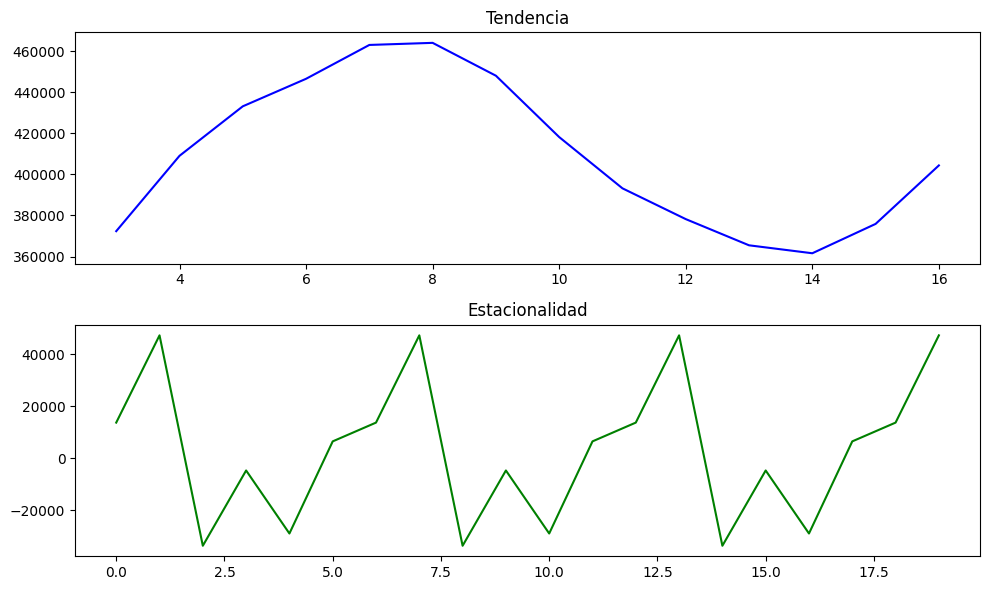

In [209]:
decompose_result = seasonal_decompose(spain_ventas['AMOUNT'], model='additive', period=6)

plt.figure(figsize=(10, 6))

# Tendencia
plt.subplot(2, 1, 1)
plt.plot(decompose_result.trend, label='Tendencia', color='blue')
plt.title('Tendencia')

# Estacionalidad
plt.subplot(2, 1, 2)
plt.plot(decompose_result.seasonal, label='Estacionalidad', color='green')
plt.title('Estacionalidad')

plt.tight_layout()
plt.show()

Aunque la tendencia general es ascendente, a partir de septie4mbre de 2023 se observa una caída, aunque al final parece recuperar un ligero repunte.

En cuanto a la estacionalidad, se identifica un ciclo que se repite aproximadamente cada 7 meses, un patrón que no era evidente sin la descomposición de la serie.

##LA MARCA CON MÁS VENTAS

In [210]:
marca_con_mas_ventas = ventas_actual.groupby('SUBBRAND')['AMOUNT'].sum().idxmax()
print(marca_con_mas_ventas)

Pepsi Max (L3)


In [211]:
pepsi_ventas = ventas_actual[ventas_actual['SUBBRAND'] == 'Pepsi Max (L3)']
pepsi_ventas.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,Fecha,MONTH_YEAR
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,NaN,1.885949e+05,2023-10-01,2023-10
724,Denmark,Pepsi Max (L3),2024,2,actual,NaN,NaN,2.557571e+06,2024-02-01,2024-02
727,Italy,Pepsi Max (L3),2024,2,actual,NaN,NaN,1.928897e+05,2024-02-01,2024-02
740,Norway,Pepsi Max (L3),2024,2,actual,NaN,NaN,2.119033e+06,2024-02-01,2024-02
836,Denmark,Pepsi Max (L3),2024,4,actual,NaN,NaN,2.090877e+06,2024-04-01,2024-04


In [212]:
pepsi_ventas = pepsi_ventas.groupby('MONTH_YEAR')['AMOUNT'].sum().reset_index()
pepsi_ventas['Fecha'] = pepsi_ventas['MONTH_YEAR'].dt.to_timestamp()

fig = px.line(pepsi_ventas, x='Fecha', y='AMOUNT', title='Ventas mensuales de Pepsi', markers=True)
fig.update_layout(xaxis_title='Fecha', yaxis_title='Amount')

fig.show()

Para el caso de Pepsi a simple vista se puede decir que la tendencia se mantiene estable, pero con una analisis más profundo podríamos llegar a que en realidad crece con el tiempo pero de manera muy ligera.

Para la estacionalidad vamos a estudiar como se comportan los picos, los meses de Enerro son los picos más bajos pero hay otro ciclo, cada cuatro meses hay un pico bajo, y entre esos meses el segundo es alto y el tercero baja hasta llegar al cuarto que es el punto más bao de esos 4 meses, por lo que hay una tendencia trimestral.

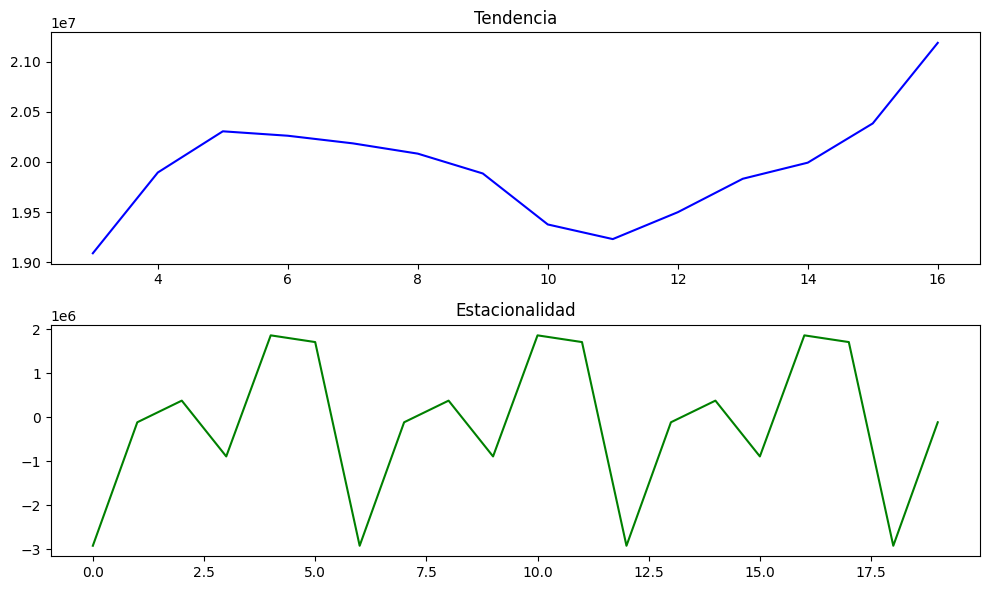

In [213]:
decompose_result = seasonal_decompose(pepsi_ventas['AMOUNT'], model='additive', period=6)

plt.figure(figsize=(10, 6))

# Tendencia
plt.subplot(2, 1, 1)
plt.plot(decompose_result.trend, label='Tendencia', color='blue')
plt.title('Tendencia')

# Estacionalidad
plt.subplot(2, 1, 2)
plt.plot(decompose_result.seasonal, label='Estacionalidad', color='green')
plt.title('Estacionalidad')

plt.tight_layout()
plt.show()

Como observamos previamente, la tendencia muestra una ligera inclinación ascendente. En cuanto a la estacionalidadd, no se aprecia un ciclo claro. Si se intenta identificar algún patrón, podría señalar una leve estacionalidad cada 4 meses, aunque este comportamiento no parece lo suficientemente significativo.

#**3. CUALES SON LAS PREDICCIONES HECHAS EN ESPAÑA Y COMO DE BUENAS SON**

In [214]:
spain_ventas_ACTUAL = ventas_actual[ventas_actual['COUNTRY'] == 'Spain']
spain_ventas_FORECAST = ventas_forecast[ventas_forecast['COUNTRY'] == 'Spain']
products = spain_ventas_FORECAST['SUBBRAND'].unique()[:6]


for product in products:
    forecast = spain_ventas_FORECAST[spain_ventas_FORECAST['SUBBRAND'] == product]
    actual = spain_ventas_ACTUAL[spain_ventas_ACTUAL['SUBBRAND'] == product]

    fig = px.scatter(
        x=forecast['Fecha'], y=forecast['AMOUNT'], labels={'x': 'Fecha', 'y': 'Amount'},
        title=f'Forecast vs Actual para {product}', color_discrete_sequence=['red']
    )
    fig.add_scatter(x=actual['Fecha'], y=actual['AMOUNT'], mode='markers', name='Actual', marker=dict(color='blue'))
    fig.show()

Vemos que las predicciones siguen el mismo patron que los actuales, con las mismas subidas y bajadas pero se alejan bastante de la venta actual de ese mes entonces para evaluar lo buenas que son todas las de esas meses calculamos la media por cada mes.

In [215]:
for product in products:

    forecast_product = spain_ventas_FORECAST[spain_ventas_FORECAST['SUBBRAND'] == product].copy()
    forecast_product.loc[:, 'MONTH_YEAR'] = forecast_product['Fecha'].dt.to_period('M')
    forecast_monthly_avg = forecast_product.groupby('MONTH_YEAR')['AMOUNT'].mean().reset_index()
    forecast_monthly_avg['Fecha'] = forecast_monthly_avg['MONTH_YEAR'].dt.to_timestamp()
    forecast_monthly_avg = forecast_monthly_avg.sort_values(by='Fecha')
    actual_product = spain_ventas_ACTUAL[spain_ventas_ACTUAL['SUBBRAND'] == product].copy()
    actual_product.loc[:, 'MONTH_YEAR'] = actual_product['Fecha'].dt.to_period('M')
    actual_monthly = actual_product.drop_duplicates(subset=['MONTH_YEAR']).reset_index(drop=True)
    actual_monthly = actual_monthly.sort_values(by='Fecha')

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=forecast_monthly_avg['Fecha'],
        y=forecast_monthly_avg['AMOUNT'],
        mode='lines',
        name='Forecast Promedio',
        line=dict(color='red')
    ))

    fig.add_trace(go.Scatter(
        x=actual_monthly['Fecha'],
        y=actual_monthly['AMOUNT'],
        mode='lines',
        name='Actual',
        line=dict(color='blue')
    ))

    fig.update_layout(
        title=f'Ventas menssuales en {product} en España',
        xaxis_title='Fecha',
        yaxis_title='Amount'
    )

    fig.show()


Dependiendo del producto las predicciones son mejores que otras, pero en general siguen un buen patron.

Por último probamos como funcionaría eligiendo la predicción más cercana:

In [216]:

mapeo = {
    'AI_P02F': 1, 'AI_P03F': 2, 'AI_P04F': 3, 'AI_P05F': 4,
    'AI_P06F': 5, 'AI_P07F': 6, 'AI_P08F': 7, 'AI_P09F': 8,
    'AI_P10F': 9, 'AI_P11F': 10, 'AI_P12F': 11, 'AI_PF': 12
}

ventas_copia = ventas[ventas['COUNTRY'] == 'Spain'].copy()
ventas_copia['FECHA'] = pd.to_datetime(ventas_copia[['YEAR', 'MONTH']].assign(DAY=1))

subbrands = ventas_copia['SUBBRAND'].unique()


for subbrand in subbrands:
    data_spain_subbrand = ventas_copia[ventas_copia['SUBBRAND'] == subbrand].copy()

    data_spain_subbrand['FECHA_REALIZACION_PREDICCION'] = pd.NaT
    forecast_condition = (data_spain_subbrand['SCENARIO'] == 'AI_forecast') & data_spain_subbrand['FORECAST_YEAR'].notna() & data_spain_subbrand['FORECAST'].notna()
    data_spain_subbrand.loc[forecast_condition, 'FECHA_REALIZACION_PREDICCION'] = pd.to_datetime({
        'year': data_spain_subbrand.loc[forecast_condition, 'FORECAST_YEAR'],
        'month': data_spain_subbrand.loc[forecast_condition, 'FORECAST'].map(lambda x: mapeo.get(x, 1)),
        'day': 1
    })


    fechas, actual_values, forecast_values = [], [], []
    for fecha, group in data_spain_subbrand.groupby('FECHA'):
        actual = group[group['SCENARIO'] == 'actual']['AMOUNT'].values
        if actual.size > 0:
            actual_value = actual[0]
            forecast_group = group[group['SCENARIO'] == 'AI_forecast'].copy()
            forecast_group['DIFF'] = (forecast_group['FECHA_REALIZACION_PREDICCION'] - fecha).abs()
            if not forecast_group.empty:
                closest_forecast = forecast_group.loc[forecast_group['DIFF'].idxmin(), 'AMOUNT']
                fechas.append(fecha)
                actual_values.append(actual_value)
                forecast_values.append(closest_forecast)

    result_df = pd.DataFrame({'FECHA': fechas, 'Actual': actual_values, 'Forecast': forecast_values})
    result_df['Error_Cuadratico'] = abs(result_df['Forecast'] - result_df['Actual'])


    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Comparación Actual y Forecast - {subbrand}", "Error Cuadrático"))
    fig.add_trace(go.Scatter(x=result_df['FECHA'], y=result_df['Actual'], mode='lines+markers', name='Actual', line=dict(color='#000000')), row=1, col=1)
    fig.add_trace(go.Scatter(x=result_df['FECHA'], y=result_df['Forecast'], mode='lines+markers', name='Forecast', line=dict(color='#a066ff')), row=1, col=1)
    fig.add_trace(go.Bar(x=result_df['FECHA'], y=result_df['Error_Cuadratico'], name='Error Cuadrático', marker=dict(color='#a066ff')), row=1, col=2)
    fig.update_layout(title_text=f'Comparación de Valores y Error Cuadrático para {subbrand}', template="simple_white")
    fig.show()

Al comparar ambas opciones, me quedaría con la media. Aunque la opción de la más cercana se ajusta bien para Pepsi Regular, en el caso de 7up se desvía considerablemente. En cambio, al usar las medias, se logra un ajuste más equilibrado para todas las marcas, obteniendo un buen resultado en general.